# TITLE: Exploring Differences in Feature Importance for Predicting Bike-Sharing System (BSS) Demand Before and After COVID-19: An Application of Machine Learning Techniques

- Word Count: 2075
- **[Gitehub Repository:0006_Data_Science](https://github.com/qiyuechen1202/0006_Data_Science)**
- **[Python Notebook:CASA0006_Assessment.ipynb](https://github.com/qiyuechen1202/0006_Data_Science/blob/main/Assessment.ipynb)**

## 1. INTRODUCTION
The research aims to explore the features that affect the daily demand for bike-sharing systems (BSS) in New York (NYC) before and after COVID-19. It will adopt machine learning (ML) techniques to predict the daily ridership demand, which can reflect the importance of these features. COVID-19 has significantly changed travel choices, and BSS as travel modes to replace public transport (PT) and to maintain social distance have been promoted (Teixeira, Silva and Moura E Sá, 2021). Evidence from Seoul and London indicates a rise in BSS ridership during the pandemic (Li et al., 2021; Goh, Choi and Song, 2023). Furthermore, some studies revealed a transformation in BSS usage from being a supplementary mode to PT to serving as an alternative for short-distance PT trips (Kim and Cho, 2022; Ma et al., 2019; Ashraf et al., 2021). Therefore, examining the factors influencing BSS demand and analysing changes pre and post-COVID-19 will aid in balancing BSS demand and supply.  

Citi Bike, the BSS in NYC, experienced a period during the pandemic when ridership declined and then gradually recovered, as shown in Figure 1 (Wang and Noland, 2021). Subsequently, ridership continued to rise, with December 2021 seeing a 74% rise in daily trips compared to December 2019 (Lyft, 2020; Lyft, 2021). Given the differences in ridership pre and post-COVID-19, the study will take Citi Bike as an example to analyse the influence of weather, travel patterns and user attributes on BSS demand in these two periods.


![Marvel](https://raw.githubusercontent.com/qiyuechen1202/0006_Data_Science/main/BSSChanges.png)

Figure 1 Changes in the Number of Citi Bike Daily Trips During COVID-19. Picture source from Wang and Noland (2021).

In [615]:
import os
from urllib.request import urlopen
from requests import get
from urllib.parse import urlparse
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import numpy as np

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

import sklearn
from sklearn.model_selection import train_test_split, GridSearchCV, validation_curve
from sklearn.metrics import mean_squared_error
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import RFE
from sklearn.svm import SVR

# random forest
from sklearn.ensemble import RandomForestRegressor

# xgboost
import xgboost
from xgboost import XGBRegressor

In [616]:
# check the library version before we start
print("xgboost version:{}".format(xgboost.__version__))
print("sklearn version:{}".format(sklearn.__version__))

xgboost version:2.0.0
sklearn version:1.3.0


In [617]:
# calculate the total loss, bias, and variance
# IN THE FIRST TIME RUNNING 
# Note: need to install the mlxtend library 
#pip install mlxtend==0.21.0
from mlxtend.evaluate import bias_variance_decomp

## 2. LITERATURE REVIEW

**The Factors Influencing the BSS Trip before and during/after COVID-19**

Various factors motivating and inhibiting BSS trip demand were discussed before COVID-19, primarily focusing on weather conditions, travel patterns, and user attributes. Moreover, several studies have examined the changes occurring before and during/after COVID-19.

**Weather Conditions**

Weather conditions display differential impacts in different cases. El-Assi, Mahmoud and Habib (2017) indicated a positive relationship between temperature and BSS demand. However, by modelling BSS demand in 2015, Kim (2018) stated that a daily temperature above 30°C would decrease BSS demand. Additionally, some studies reported that precipitation and wind speed negatively correlate with BSS demand (Kim, 2017; Chibwe et al., 2021). Conversely, Ashqar, Elhenawy, and Rakha (2019), in their study of modelling BSS trips in San Francisco Bay Area, found that precipitation was not a significant predictor, possibly due to the relatively small precipitation types in the area. Thus, it is essential to examine the influence of weather conditions on BSS demand in NYC since weather conditions have varying degrees of importance across different geographic areas. 

**Travel Patterns**

The impacts of travel patterns are measured by trip duration and day type. El-Assi, Mahmoud, and Habib (2017) reported that trip distance is negatively correlated to BSSl trips in Toronto. Shorter travel times significantly boost BSS demand in the Netherlands (Engbers and Hendriksen, 2010). However, in their study of three US cities during COVID-19, Padmanabhan et al.(2021) revealed that although BSS trips decreased, the average travel time increased.   

Chibwe et al. (2021) revealed that BSS demand in London decreases by 17.4% on weekends compared to weekdays. In contrast, Corcoran et al.(2014) observed a positive correlation between weekends and BSS usage in Brisbane, Australia. Moreover, Kim (2018) did not identify a difference in BSS demand between weekdays and weekends. Thus, the impacts of day type on BSS demand can be further studied.


**User Attributes** 

Gender and user type have been discussed as user factors influencing demand and have reflected notable changes across two periods. In 2019, females in Texas reported lower BSS demand than males (Blazanin et al., 2022). Similarly, this gender difference was evident in pre-pandemic New York(Reilly, Wang and Crossa, 2022). However, Uddin, Hwang and Hasine (2023) examined the BSS demand in NYC before and during COVID, revealing an opposite trend: female users demonstrated greater BSS demand than males during the pandemic.  

Bachand-Marleau, Lee and Geneidy (2012) studied the impact of user types on BSS demand in Montreal, Canada, finding that member users significantly contributed to increased trips. By contrast, Jia et al. (2023) discovered in Washington D.C. that while BSS trips by member users declined during the pandemic, trips by casual users surged by 40% due to policies promoting mode shift to BSS. Therefore, it is necessary to examine the impact of these variables on BSS demand after COVID-19, offering insights into the management and supply of BSS.


**The Machine Learning (ML) Techniques for Predicting BSS Demand** 

Previous studies have explored applying ML techniques to predict BSS demand. Studies by Feng and Wang (2017) demonstrated the effectiveness of Random Forest (RF) on this topic, attributing its advantages to ensemble learning systems that combine different decision trees to enhance accuracy and mitigate overfitting (Li and Axhausen, 2019). Meanwhile, XGBoost (eXtreme Gradient Boosting), another ensemble learning for gradient boosting, has emerged as a promising approach for the prediction (Hu et al., 2022; Uddin, Hwang, and Hasnine, 2023). Notably, Lainjo (2020) reported higher accuracy of XGBoost compared to RF. Thus, this research aims to compare the performance of RF and XGBoost in predicting BSS demand.


## 3. RESEARCH QUESTION

Before COVID-19, BSS riderships were influenced by weather, travel patterns, and user attributes. However, the post-COVID-19 changes still require analysis. Thus, the research questions are:

- How can ML methods, particularly Random Forest and XGBoost, be effectively utilised to predict daily BSS demand?

- Which variables demonstrate changes in relative importance for predicting BSS demand before and after COVID-19?



## 4. PRESENTATION OF DATA


The research adopts Citi Bike in NYC as the study objective, integrating BSS trip data with daily weather data to predict demand for BSS. Lyft, the operator of Citi Bike, has opened trip data from 2013 to the present, which is conducive to the time series analysis. The dataset provides trip details, including temporal, geographical and user information. 

**Target Variable:**   
**Daily BSS Trips before and after COVID-19**

To observe the change in BSS demand before and after COVID-19, BSS trip data, as the target variable, are divided into two periods. NYC reported the first case on March 2nd, 2020, and announced the first phase of reopening on June 8th, 2020 (Wang and Noland, 2021). Thus, BSS trips from September 2019 to February 2020 are defined as pre-pandemic data, and BSS trips from June 2020 to December 2020 are retrieved as post-pandemic data. Furthermore, the single trips are aggregated into daily total trips, which can correlate with daily weather data. After the data cleaning, the pre-pandemic period of 177 days and the post-pandemic period of 191 days are involved in the research. Table 1 lists the variables and their definitions, and Figure 2 shows the data distribution difference of daily total trips before and after COVID-19.

Table 1 The list of variables
<br>
|Aspects|Variable Name|Definition|Unit|
|:---|:---|:---|:---|
|Target Variable| Daily BSS Trip(Before)| Daily BSS trip from September 2019 to February 2020|Count|
||Daily Bike Trip(After)|Daily BSS trip from June 2020 to December 2020|Count|
|Features||||
|Weather Conditions|Average Temperature|Average temperature for the day|Fahrenheit(F)|
||Heating Degree Days (HDD) |The degrees of cold conditions (Lower than 65F) for the day |Fahrenheit(F)|
||Cooling Degree Days (CDD)|The degrees of hot conditions (Higher than 65F) for the day |Fahrenheit(F)|
||Total Liquid Content (TLC)|The water equivalent number of precipitation for the day|Inches(in)|
||Average Wind Speed|Daily average wind speed |Miles per hour|
|Travel Pattern| The Proportion of Trip Duration (within 15mins)|The Proportion of trip duration within 15mins for the day|%|
||The Proportion of Trip Duration (15 - 30mins)|The Proportion of trip duration between 15 to 30mins for the day|%|
||The Proportion of Trip Duration (above 30mins)|The Proportion of trip duration above 30 mins for the day|%|
||Day Type|The distinguish of weekday (1) and weekend (0) |None|
|User Attributes|Gender|The daily proportion of female and male users|%|
|| User Types|The daily proportion of customer(4-hour pass or 3-day pass user)|%|
|||The daily proportion of subscriber(annual member)|%|




**Features:**  
**Weather Conditions**  

The research employs five daily weather variables collected by the National Oceanic and Atmospheric Administration (NOAA) [(2024a)](https://www.ncdc.noaa.gov/cdo-web/datasets/LCD/stations/WBAN:94728/detail) NYC. Furthermore, based on the extreme weather events reported by NOAA [(2024b)](https://www.weather.gov/okx/stormevents) (Table 2), the data for these days are removed to reduce outlier impacts.
<br>
<br>
Table 2 The Extreme Weather Events (Source from [National Weather Service(2024)](https://www.weather.gov/okx/stormevents))
|Period|Date|Event|
|:---|:---|:---|
|Before COVID_19(Sep2019 to Feb 2020)| 2019-12-18| Snow Squall Event|
|After COVID_19(Jun 2020 to Dec 2020)|2020-06-06|Cold Front and Afternoon Thunderstorms|
||2020-07-10 |Tropical Storm Fay|
||2020-08-04|Tropical Storm Isaias|
||2020-08-27|EF-1 Tornadoes and Severe Weather|
||2020-12-16|Winter Storm|
||2020-12-17|Winter Storm|

**Travel Patterns and User Attributes**  

The duration of each trip is classified into three categories: within 15 minutes, 15 to 30 minutes, and above 30 minutes.  During the data aggregation stage, the trip percentage in each category is calculated. Besides, the day type is categorised into weekdays and weekends, and encoded to a dummy variable. Regarding user attributes, user type and gender provided by Citi bike data are also categorised, and the trip percentage for each type is calculated. The statistical summaries of variables before and after COVID-19 are shown in Table 3 and Table 4, respectively.


In [618]:
# Data loading 

# Note: Due to limitations caused by the large size of the original data,
# sections 4.1 and 4.2 show the code for the data preprocessing and cleaning 
# to help understand the data processing process.
# Sections 4.1 is Data_load.ipynb on Github
# https://github.com/qiyuechen1202/0006_Data_Science/blob/main/Data_load.ipynb
# Sections 4.2 is Data_processing.ipynb on Github
# https://github.com/qiyuechen1202/0006_Data_Science/blob/main/Data_processing.ipynb

In [619]:
# 4.1 Load the original data
# trip data before Covid-19
# time range: from September 2019 to February 2020 
# There is 16 csv files 
if False: 
    Before_bike = pd.DataFrame()  
    folder_path = "data/Before/"  
    for file_name in os.listdir(folder_path):
        if file_name.endswith('.csv'):
            ile_path = os.path.join(folder_path, file_name)  
            df = pd.read_csv(file_path)  
            Before_bike = pd.concat([Before_bike, df], ignore_index=True) 
    #check the dataframe
    Before_bike #There is 11703041 trip data
    Before_bike.drop(columns=['start station name', 'start station latitude',
                              'start station longitude','end station id','end station name',
                              'end station latitude','end station longitude','bikeid',
                              'birth year'], inplace=True)
    # export the before data
    Before_bike.to_csv("Before_bike.csv", index=False)
# trip data after Covid-19
# time range: from June 2020 to December 2020
# There is 18 csv files 
if False: 
    After_bike = pd.DataFrame()  
    folder_path_1 = "data/After/"
    for file_name in os.listdir(folder_path_1):
        if file_name.endswith('.csv'):
            file_path = os.path.join(folder_path_1, file_name)  
            df = pd.read_csv(file_path) 
            After_bike = pd.concat([After_bike, df], ignore_index=True) 
    #check the dataframe
    After_bike # There is 13880322 trip data
    After_bike.drop(columns=['start station name', 'start station latitude',
                             'start station longitude','end station id',
                             'end station name','end station latitude','end station longitude',
                             'bikeid','birth year'], inplace=True)
    # export the after data
    After_bike.to_csv("After_bike.csv", index=False)
print("4.1 load the original data completed, continuing execution with the following code.")

4.1 load the original data completed, continuing execution with the following code.


In [620]:
# 4.2 Merge the data by the date and calculate the variables
# before
if False:
    # read the before data
    Before = pd.read_csv("Before_bike.csv")
    # data preprocessing 
    # Trip duration
    # Change units from seconds to minutes
    Before['tripduration_minutes'] = Before['tripduration'] / 60
    # Create three categorical dummy variables 
    Before['duration_category'] = pd.cut(Before['tripduration_minutes'], 
                                         bins=[0, 15, 30, np.inf], 
                                         labels=['within_15min', '15-30mins', 'above30mins'])
    Before = pd.get_dummies(Before, columns=['duration_category'])
    # Uer types
    # Create the dummy variable
    Before = pd.get_dummies(Before, columns=['usertype'])
    # gender
    # delete the NaN value in Gender Column
    Before = Before[Before['gender'] != 0] #results: has 9,714,849 rows
    # Create the dummy variable
    Before['gender'] = Before['gender'].replace({1: 'Male', 2: 'Female'})
    Before = pd.get_dummies(Before, columns=['gender'])
    # Aggregate data by date
    # set the data types of datetime variable
    Before['date'] = pd.to_datetime(Before['starttime']).dt.date
    # Aggregate the trip numbers by date
    daily_Before = Before.groupby('date').agg(
        total_trips=('tripduration_minutes', 'count'),  # Daily total trips
        trips_within_15min=('duration_category_within_15min', 'sum'),  
        # The daily trip number within 15 minutes
        trips_15_to_30min=('duration_category_15-30mins', 'sum'),  
        # The daily trip number between 15 to 30 minutes
        trips_above30min=('duration_category_above30mins', 'sum'),  
        # The daily trip number above 30 minutes
        Customer_trips=('usertype_Customer', 'sum'),  
        # Daily trip number of customers 
        Subscriber_trips=('usertype_Subscriber', 'sum'),  
        # Daily trip number of subscriber
        Female_trips=('gender_Female', 'sum')  
        # Daily trip number of female
    )
    # Calculate the proportion of each variable in total daily trips
    daily_Before['percentage_within_15min'] = daily_Before['trips_within_15min'] / daily_Before['total_trips']
    daily_Before['percentage_15_to_30min'] = daily_Before['trips_15_to_30min'] / daily_Before['total_trips']
    daily_Before['percentage_above30min'] = daily_Before['trips_above30min'] / daily_Before['total_trips']
    daily_Before['percentage_Customer'] = daily_Before['Customer_trips'] / daily_Before['total_trips']
    daily_Before['percentage_Subscriber'] = daily_Before['Subscriber_trips'] / daily_Before['total_trips']
    daily_Before['percentage_Female'] = daily_Before['Female_trips'] / daily_Before['total_trips']
    daily_Before['percentage_Male'] = 1 - daily_Before['Female_trips'] / daily_Before['total_trips']
    # create the new dataframe
    daily_Before_pre = daily_Before[[
    'total_trips',
    'percentage_within_15min','percentage_15_to_30min','percentage_above30min',
        'percentage_Customer','percentage_Subscriber',
        'percentage_Female','percentage_Male']]
    # reset the index
    daily_Before_pre.reset_index(inplace=True)
    # export the before data
    daily_Before_pre.to_csv("before_pre.csv",index=False)

# After
if False: 
    # read the after data
    After = pd.read_csv("After_bike.csv")
    # data preprocessing 
    # Trip duration
    # Change units from seconds to minutes
    After['tripduration_minutes'] = After['tripduration'] / 60
    # Create three categorical dummy variables 
    After['duration_category'] = pd.cut(After['tripduration_minutes'], 
                                        bins=[0, 15, 30, np.inf], 
                                        labels=['within_15min', '15-30mins', 'above30mins'])
    After = pd.get_dummies(After, columns=['duration_category'])
    # Uer types
    # Create the dummy variable
    After = pd.get_dummies(After, columns=['usertype'])
    # gender
    # delete the NaN value in Gender Column
    After = After[After['gender'] != 0] #results: has 12,207,549 rows
    # Create the dummy variable
    After['gender'] = After['gender'].replace({1: 'Male', 2: 'Female'})
    After = pd.get_dummies(After, columns=['gender'])
    # Aggregate data by date
    # set the data types of datetime variable
    After['date'] = pd.to_datetime(After['starttime']).dt.date
    # Aggregate the trip numbers by date
    daily_After = After.groupby('date').agg(
        total_trips=('tripduration_minutes', 'count'),  # daily total trips
        trips_within_15min=('duration_category_within_15min', 'sum'),  
        # The daily trip number within 15 minutes
        trips_15_to_30min=('duration_category_15-30mins', 'sum'),  
        # The daily trip number between 15 to 30 minutes
        trips_above30min=('duration_category_above30mins', 'sum'),  
        # The daily trip number above 30 minutes
        Customer_trips=('usertype_Customer', 'sum'),  
        # Daily trip number of customers 
        Subscriber_trips=('usertype_Subscriber', 'sum'),  
        # Daily trip number of subscriber
        Female_trips=('gender_Female', 'sum') 
        # Daily trip number of female
    )
    # Calculate the proportion of each variable in total daily trips
    daily_After['percentage_within_15min'] = daily_After['trips_within_15min'] / daily_After['total_trips']
    daily_After['percentage_15_to_30min'] = daily_After['trips_15_to_30min'] / daily_After['total_trips']
    daily_After['percentage_above30min'] = daily_After['trips_above30min'] / daily_After['total_trips']
    daily_After['percentage_Customer'] = daily_After['Customer_trips'] / daily_After['total_trips']
    daily_After['percentage_Subscriber'] = daily_After['Subscriber_trips'] / daily_After['total_trips']
    daily_After['percentage_Female'] = daily_After['Female_trips'] / daily_After['total_trips']
    daily_After['percentage_Male'] = 1 - daily_After['Female_trips'] / daily_After['total_trips']
    # create the new dataframe
    daily_After_pre = daily_After[[
        'total_trips',
        'percentage_within_15min','percentage_15_to_30min','percentage_above30min',
        'percentage_Customer','percentage_Subscriber',
        'percentage_Female','percentage_Male']]
    # reset the index
    daily_After_pre.reset_index(inplace=True)
    # export the after data
    daily_After_pre.to_csv("after_pre.csv", index=False) 
print("4.2 Merge and calcualtion completed, continuing execution with the following code.")

4.2 Merge and calcualtion completed, continuing execution with the following code.


In [621]:
# 4.3 Reload the data
Daily_Before = pd.read_csv("https://raw.githubusercontent.com/qiyuechen1202/0006_Data_Science/main/before_pre.csv")
Daily_After = pd.read_csv("https://raw.githubusercontent.com/qiyuechen1202/0006_Data_Science/main/after_pre.csv")
Climate = pd.read_csv("https://raw.githubusercontent.com/qiyuechen1202/0006_Data_Science/main/climate.csv") 

# change the date type
Daily_Before ['date'] = pd.to_datetime(Daily_Before ['date'])
Daily_After ['date'] = pd.to_datetime(Daily_After ['date'])
Climate['date'] = pd.to_datetime(Climate['date'])

# merge the data
Before = Daily_Before.merge(Climate,how='left', on='date')
After = Daily_After.merge(Climate,how='left', on='date')
# check the data
Before.head(5)

,date,total_trips,percentage_within_15min,percentage_15_to_30min,percentage_above30min,percentage_Customer,percentage_Subscriber,percentage_Female,percentage_Male,Avg_temperature (F),Heat,Cool,Weather Type,TLC_Precipitation (in),Avg_Speed_Wind
0,2019-08-01,82156,0.695470,0.234213,0.070317,0.080846,0.919154,0.259871,0.740129,79,0.0,14.0,BR,0,2.2
1,2019-08-02,75731,0.681702,0.243229,0.075068,0.097939,0.902061,0.266337,0.733663,79,0.0,14.0,NaN,0,3.5
2,2019-08-03,65371,0.584403,0.294764,0.120833,0.204494,0.795506,0.319270,0.680730,77,0.0,12.0,RA BR,0.21,3.6
3,2019-08-04,57344,0.615653,0.274920,0.109427,0.191633,0.808367,0.308664,0.691336,78,0.0,13.0,BR,0,2.6
4,2019-08-05,75689,0.674946,0.247922,0.077131,0.095932,0.904068,0.267423,0.732577,76,0.0,11.0,NaN,0,4.4


In [622]:
# check the data
After.head(5)

,date,total_trips,percentage_within_15min,percentage_15_to_30min,percentage_above30min,percentage_Customer,percentage_Subscriber,percentage_Female,percentage_Male,Avg_temperature (F),Heat,Cool,Weather Type,TLC_Precipitation (in),Avg_Speed_Wind
0,2020-06-01,46138,0.470458,0.321080,0.208462,0.191729,0.808271,0.341974,0.658026,61,4.0,0.0,NaN,0,NaN
1,2020-06-02,40581,0.453168,0.327912,0.218920,0.179246,0.820754,0.348217,0.651783,66,0.0,1.0,RA,T,NaN
2,2020-06-03,25915,0.514451,0.305499,0.180050,0.139958,0.860042,0.345939,0.654061,70,0.0,5.0,RA BR,0.45,NaN
3,2020-06-04,35301,0.470185,0.312314,0.217501,0.174528,0.825472,0.360245,0.639755,75,0.0,10.0,RA BR,0.16,NaN
4,2020-06-05,29935,0.533389,0.293903,0.172708,0.143578,0.856422,0.341440,0.658560,74,0.0,9.0,RA BR,0.26,NaN


In [623]:
# check the data type
Before.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183 entries, 0 to 182
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   date                     183 non-null    datetime64[ns]
 1   total_trips              183 non-null    int64         
 2   percentage_within_15min  183 non-null    float64       
 3   percentage_15_to_30min   183 non-null    float64       
 4   percentage_above30min    183 non-null    float64       
 5   percentage_Customer      183 non-null    float64       
 6   percentage_Subscriber    183 non-null    float64       
 7   percentage_Female        183 non-null    float64       
 8   percentage_Male          183 non-null    float64       
 9   Avg_temperature (F)      183 non-null    int64         
 10  Heat                     183 non-null    float64       
 11  Cool                     183 non-null    float64       
 12  Weather Type             82 non-null

In [624]:
# check the data type
After.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214 entries, 0 to 213
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   date                     214 non-null    datetime64[ns]
 1   total_trips              214 non-null    int64         
 2   percentage_within_15min  214 non-null    float64       
 3   percentage_15_to_30min   214 non-null    float64       
 4   percentage_above30min    214 non-null    float64       
 5   percentage_Customer      214 non-null    float64       
 6   percentage_Subscriber    214 non-null    float64       
 7   percentage_Female        214 non-null    float64       
 8   percentage_Male          214 non-null    float64       
 9   Avg_temperature (F)      214 non-null    int64         
 10  Heat                     214 non-null    float64       
 11  Cool                     214 non-null    float64       
 12  Weather Type             98 non-null

In [625]:
# Data Cleaning

# Weather conditions
# delete extreme climate
# Before:  extreme climate （2019-12-18）
Before = Before[Before['date'] != '2019-12-18']
# After:  extreme climate （'2020-06-06', '2020-07-10','2020-08-04',
#'2020-08-27', '2020-12-16','2020-12-17')
After = After [~After ['date'].isin(['2020-06-06', '2020-07-10',
                                     '2020-08-04', '2020-08-27',
                                     '2020-12-16','2020-12-17'])]
 
# HDD and CDD: rename 
# Before: 
Before  = Before.rename(columns={'Heat': 'HDD'})
Before  = Before.rename(columns={'Cool ': 'CDD'})
# After: 
After = After.rename(columns={'Heat': 'HDD'})
After = After.rename(columns={'Cool ': 'CDD'})

# TLC_Precipitation
# Regarding 'TLC_Precipitation (in)', 
# it has value T, a trace amount of precipitation. 
# A trace amount of precipitation means that the amount of precipitation 
# is very small, almost negligible.
# Thus, the value T is changed to 0
# Before: 
Before['TLC_Precipitation (in)'] = Before['TLC_Precipitation (in)'].replace('T', 0)
# After: 
After['TLC_Precipitation (in)'] = After['TLC_Precipitation (in)'].replace('T', 0)

# Avg_Speed_Wind
# 'Avg_Speed_Wind' has NaN value, drop it
Before = Before[Before['Avg_Speed_Wind'] != 'na']
After = After.dropna(subset=['Avg_Speed_Wind'])

# Travel Pattern
# increase day type variable weekday (1) weekend (0)
# Before
Before['weekday'] = Before['date'].dt.weekday
Before['is_weekday'] = Before['weekday'].apply(lambda x: 1 if x < 5 else 0)
Before = Before.drop('weekday', axis=1)
# After
After['weekday'] = After['date'].dt.weekday
After['is_weekday'] = After['weekday'].apply(lambda x: 1 if x < 5 else 0)
After = After.drop('weekday', axis=1)

# drop the column
# Before
Before = Before.drop('Weather Type', axis=1)
# After
After = After.drop('Weather Type', axis=1)

In [626]:
# check NaN value
Before.isna().sum()

date                       0
total_trips                0
percentage_within_15min    0
percentage_15_to_30min     0
percentage_above30min      0
percentage_Customer        0
percentage_Subscriber      0
percentage_Female          0
percentage_Male            0
Avg_temperature (F)        0
HDD                        0
CDD                        0
TLC_Precipitation (in)     0
Avg_Speed_Wind             0
is_weekday                 0
dtype: int64

In [627]:
# check NaN value
After.isna().sum()

date                       0
total_trips                0
percentage_within_15min    0
percentage_15_to_30min     0
percentage_above30min      0
percentage_Customer        0
percentage_Subscriber      0
percentage_Female          0
percentage_Male            0
Avg_temperature (F)        0
HDD                        0
CDD                        0
TLC_Precipitation (in)     0
Avg_Speed_Wind             0
is_weekday                 0
dtype: int64

In [628]:
Before['TLC_Precipitation (in)'] = Before['TLC_Precipitation (in)'].astype(float)
Before['Avg_Speed_Wind'] = Before['Avg_Speed_Wind'].astype(float)
# check the data type
Before.info()

<class 'pandas.core.frame.DataFrame'>
Index: 177 entries, 0 to 182
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   date                     177 non-null    datetime64[ns]
 1   total_trips              177 non-null    int64         
 2   percentage_within_15min  177 non-null    float64       
 3   percentage_15_to_30min   177 non-null    float64       
 4   percentage_above30min    177 non-null    float64       
 5   percentage_Customer      177 non-null    float64       
 6   percentage_Subscriber    177 non-null    float64       
 7   percentage_Female        177 non-null    float64       
 8   percentage_Male          177 non-null    float64       
 9   Avg_temperature (F)      177 non-null    int64         
 10  HDD                      177 non-null    float64       
 11  CDD                      177 non-null    float64       
 12  TLC_Precipitation (in)   177 non-null    

In [629]:
After['TLC_Precipitation (in)'] = After['TLC_Precipitation (in)'].astype(float)
After['Avg_Speed_Wind'] = After['Avg_Speed_Wind'].astype(float)
# check the data type
After.info()

<class 'pandas.core.frame.DataFrame'>
Index: 191 entries, 18 to 213
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   date                     191 non-null    datetime64[ns]
 1   total_trips              191 non-null    int64         
 2   percentage_within_15min  191 non-null    float64       
 3   percentage_15_to_30min   191 non-null    float64       
 4   percentage_above30min    191 non-null    float64       
 5   percentage_Customer      191 non-null    float64       
 6   percentage_Subscriber    191 non-null    float64       
 7   percentage_Female        191 non-null    float64       
 8   percentage_Male          191 non-null    float64       
 9   Avg_temperature (F)      191 non-null    int64         
 10  HDD                      191 non-null    float64       
 11  CDD                      191 non-null    float64       
 12  TLC_Precipitation (in)   191 non-null   

In [630]:
# Descriptive Analysis
# drop the date column
Before_nodate = Before.drop('date', axis=1)
After_nodate = After.drop('date', axis=1)

In [631]:
Before_summary = Before_nodate.describe().round(2)
# Statitsic result of Before  COVID-19
# Target Variable & Feature: Weather Conditions
print('Table 3: The Statitsic Summary of the Variables before COVID-19')
Before_summary.iloc[:, [0] + list(range(8, 13))]

Table 3: The Statitsic Summary of the Variables before COVID-19


,total_trips,Avg_temperature (F),HDD,CDD,TLC_Precipitation (in),Avg_Speed_Wind
count,177.00,177.00,177.00,177.00,177.00,177.00
mean,53615.24,55.33,12.66,3.05,0.12,5.28
std,20865.78,16.10,12.60,4.93,0.30,2.35
min,10251.00,21.00,0.00,0.00,0.00,2.10
25%,37044.00,41.00,0.00,0.00,0.00,3.50
50%,53964.00,56.00,9.00,0.00,0.00,4.60
75%,71077.00,70.00,24.00,5.00,0.07,6.30
max,88478.00,82.00,44.00,17.00,1.83,12.80


In [632]:
# Target Variable & Feature: Travel Parttern
print('Table 3: The Statistical Summary of the Variables before COVID-19 (Continued)')
Before_summary.iloc[:, list(range(1,4)) + [13]]

Table 3: The Statistical Summary of the Variables before COVID-19 (Continued)


,percentage_within_15min,percentage_15_to_30min,percentage_above30min,is_weekday
count,177.00,177.00,177.00,177.00
mean,0.72,0.22,0.06,0.72
std,0.06,0.04,0.02,0.45
min,0.55,0.14,0.03,0.00
25%,0.68,0.19,0.05,0.00
50%,0.73,0.22,0.06,1.00
75%,0.77,0.24,0.07,1.00
max,0.82,0.34,0.14,1.00


In [633]:
# Target Variable & Feature: User Attributes
print('Table 3: The Statistical Summary of the Variables before COVID-19 (Continued)')
Before_summary.iloc[:, 4:8]

Table 3: The Statistical Summary of the Variables before COVID-19 (Continued)


,percentage_Customer,percentage_Subscriber,percentage_Female,percentage_Male
count,177.00,177.00,177.00,177.00
mean,0.09,0.91,0.26,0.74
std,0.05,0.05,0.03,0.03
min,0.02,0.65,0.20,0.66
25%,0.05,0.90,0.24,0.73
50%,0.08,0.92,0.26,0.74
75%,0.10,0.95,0.27,0.76
max,0.35,0.98,0.34,0.80


In [634]:
# After 
After_summary = After_nodate.describe().round(2)
# Statitsic result of Before  COVID-19
# Target Variable & Feature: Weather Conditions
print('Table 4: The Statitsic Summary of the Variables after COVID-19')
After_summary.iloc[:, [0] + list(range(8, 13))]

Table 4: The Statitsic Summary of the Variables after COVID-19


,total_trips,Avg_temperature (F),HDD,CDD,TLC_Precipitation (in),Avg_Speed_Wind
count,191.00,191.00,191.00,191.00,191.00,191.00
mean,58345.75,63.68,6.99,5.98,0.13,4.60
std,17125.03,15.86,10.11,6.89,0.31,2.96
min,10384.00,6.00,0.00,0.00,0.00,0.80
25%,47530.00,52.00,0.00,0.00,0.00,2.90
50%,61468.00,67.00,0.00,2.00,0.00,4.10
75%,71439.00,77.50,13.00,12.50,0.04,5.80
max,85966.00,87.00,39.00,22.00,1.76,33.40


In [635]:
# Target Variable & Feature: Travel Parttern
print('Table 4: The Statistical Summary of the Variables before COVID-19 (Continued)')
After_summary.iloc[:, list(range(1,4)) + [13]]

Table 4: The Statistical Summary of the Variables before COVID-19 (Continued)


,percentage_within_15min,percentage_15_to_30min,percentage_above30min,is_weekday
count,191.00,191.00,191.00,191.00
mean,0.59,0.28,0.13,0.71
std,0.08,0.04,0.04,0.46
min,0.41,0.19,0.06,0.00
25%,0.54,0.25,0.10,0.00
50%,0.58,0.29,0.13,1.00
75%,0.64,0.30,0.16,1.00
max,0.74,0.35,0.24,1.00


In [636]:
# Target Variable & Feature: User Attributes
print('Table 4: The Statistical Summary of the Variables after COVID-19 (Continued)')
After_summary.iloc[:, 4:8]

Table 4: The Statistical Summary of the Variables after COVID-19 (Continued)


,percentage_Customer,percentage_Subscriber,percentage_Female,percentage_Male
count,191.00,191.00,191.00,191.00
mean,0.16,0.84,0.33,0.67
std,0.05,0.05,0.03,0.03
min,0.06,0.71,0.23,0.62
25%,0.12,0.81,0.31,0.65
50%,0.15,0.85,0.33,0.67
75%,0.19,0.88,0.35,0.69
max,0.29,0.94,0.38,0.77


Text(0, 0.5, 'Total Trip(counts)')

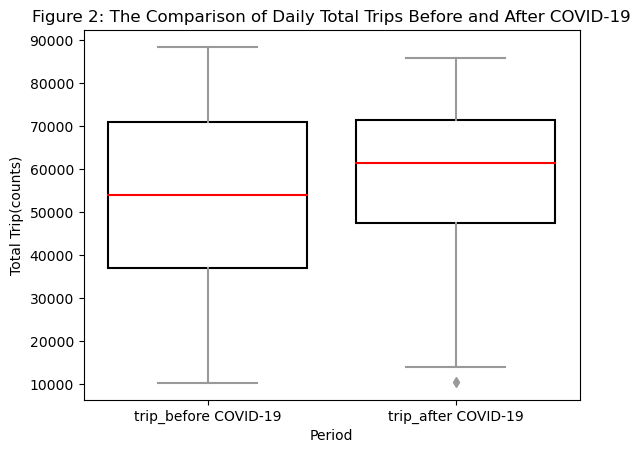

In [637]:
# Look at the difference of daily total trip before and after COVD-19
trip_before = Before_nodate['total_trips']
trip_after = After_nodate['total_trips']

trip = pd.concat([trip_before, trip_after], keys=['trip_before COVID-19', 'trip_after COVID-19'])

# box plot
sns.boxplot(x=trip.index.get_level_values(0), y=trip.values, color="white", 
            boxprops=dict(edgecolor="black"), medianprops=dict(color="red"))

plt.title('Figure 2: The Comparison of Daily Total Trips Before and After COVID-19')
plt.xlabel('Period')
plt.ylabel('Total Trip(counts)')

## 5. METHODOLOGY
The research adopts RF and XGBoost to predict daily BSS demand before and after COVID-19. The research workflow mainly consists of four parts. 

### 5.1 Selecting the Features

Selecting features is essential to effectively filter the subset of features that have the most importance, which increases the model performance. The efficiency of Recursive Feature Elimination (RFE) has been proved by Gregorutti, Michel and Saint-Pierre(2017). REF refers to using an estimator to recursively rank the importance of features and remove the less important features. Thus, the research adopts the REF function provided by Sklearn [(no date_a)](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html) and configured it to employ random forest regression as the estimator, aiming to extract the top 8 most important features(Tabel 5).

Table 5 The Recursive Feature Elimination(RFE) Results of Feature Selection
|Before COVID-19|After COVID-19|
|:---|:---|
| percentage_15_to_30min| percentage_15_to_30min|
|percentage_Customer|percentage_above30min|
|percentage_Subscriber|percentage_Customer|
|percentage_Female|percentage_Female|
|percentage_Male|percentage_Male|
|Avg_temperature (F)|Avg_temperature (F)|
|HDD|HDD|
|TLC_Precipitation (in)|CDD|


In [638]:
# set independent variable and dependent variable
X_B = Before_nodate.drop(columns=['total_trips'])  
y_B = Before_nodate['total_trips']

# create a RandomForestRegressor as an estimator
estimator = RandomForestRegressor()

# Create an RFE selector,set the number of features to retain as 8
selector_B = RFE(estimator, n_features_to_select= 8, step=1)

# to fit the RFE selector to select features
selector_B.fit(X_B, y_B)

# extract the result information
selected_feature_B = X_B.columns[selector_B.support_]
support_status_B = selector_B.support_
ranking_B = selector_B.ranking_

# Print selected features
print("Selected features:", selected_feature_B)

# Get the number of selected features
print("Number of selected features:", sum(selector_B.support_))

# Print feature support status
print("Support status of features:", selector_B.support_)

Selected features: Index(['percentage_15_to_30min', 'percentage_Customer',
       'percentage_Subscriber', 'percentage_Female', 'percentage_Male',
       'Avg_temperature (F)', 'HDD', 'TLC_Precipitation (in)'],
      dtype='object')
Number of selected features: 8
Support status of features: [False  True False  True  True  True  True  True  True False  True False
 False]


In [639]:
Before_nodate = Before_nodate[['total_trips',
                               'percentage_15_to_30min', 
                               'percentage_Customer',
                               'percentage_Subscriber', 
                               'percentage_Female', 
                               'percentage_Male',
                               'Avg_temperature (F)', 
                               'HDD', 'TLC_Precipitation (in)']]

In [640]:
# set independent variable and dependent variable
X_A = After_nodate.drop(columns=['total_trips']) 
y_A = After_nodate['total_trips']

# create a RandomForestRegressor as an estimator
estimator = RandomForestRegressor()


# Create an RFE selector,set the number of features to retain as 8
selector_A = RFE(estimator, n_features_to_select= 8, step=1)

# to fit the RFE selector to select features
selector_A.fit(X_A, y_A)

# extract the result information
selected_feature_A = X_A.columns[selector_A.support_]
support_status_A = selector_A.support_
ranking_A = selector_A.ranking_

# Print selected features
print("Selected features:", selected_feature_A)

# Get the number of selected features
print("Number of selected features:", sum(selector_A.support_))

# Print feature support status
print("Support status of features:", selector_A.support_)

Selected features: Index(['percentage_15_to_30min', 'percentage_above30min',
       'percentage_Customer', 'percentage_Female', 'percentage_Male',
       'Avg_temperature (F)', 'HDD', 'CDD'],
      dtype='object')
Number of selected features: 8
Support status of features: [False  True  True  True False  True  True  True  True  True False False
 False]


In [641]:
After_nodate = After_nodate[['total_trips',
                             'percentage_15_to_30min', 
                             'percentage_above30min', 
                             'percentage_Customer',
                             'percentage_Female',
                             'percentage_Male', 
                             'Avg_temperature (F)', 
                             'HDD', 'CDD',
                            ]]

### 5.2 Training Models & Tuning Hyperparameters

After feature selection, the two-period datasets are randomly divided into training sets (75%) and testing sets (25%). Based on the predefined ranges of hyperparameters, 10-fold cross-validation by a grid search algorithm is employed on training sets, which can find the best configuration of hyperparameters. Subsequently, the final models are constructed using the best hyperparameters and training sets. Python Sklearn Version1.3.0 and XGBoost Version2.0.0 are used to support RF and XGBoost, respectively.

In [642]:
# split train (75%) and test (25%)
# before
random_state_split = 100
train_x_B, test_x_B, train_y_B, test_y_B = train_test_split(Before_nodate.drop(['total_trips'], axis = 1), Before_nodate.total_trips, random_state=random_state_split)
# check the shape
print(train_x_B.shape)
print(train_y_B.shape)
print(test_x_B.shape)
print(test_y_B.shape)

# check the index of train_x and train_y - they should be identical. 
# The index indicates which rows from the original data.
print(train_x_B.index.identical(train_y_B.index))
print(test_x_B.index.identical(test_y_B.index))

(132, 8)
(132,)
(45, 8)
(45,)
True
True


In [643]:
# split train (75%) and test (25%)
# after
random_state_split = 100
train_x_A, test_x_A, train_y_A, test_y_A = train_test_split(After_nodate.drop(['total_trips'], axis = 1), After_nodate.total_trips, random_state=random_state_split)
# check the shape
print(train_x_A.shape)
print(train_y_A.shape)
print(test_x_A.shape)
print(test_y_A.shape)

# check the index of train_x and train_y - they should be identical. 
# The index indicates which rows from the original data.
print(train_x_A.index.identical(train_y_A.index))
print(test_x_A.index.identical(test_y_A.index))

(143, 8)
(143,)
(48, 8)
(48,)
True
True


#### (a) Random Forest

In [644]:
# Before: Random Forest
# values of max_depth and min_samples_split
hyperparameters = {'max_depth':[10,20,30,40,50], 
                   'min_samples_split':[2,4,6,8,10]}

randomState_dt = 10000
rf = RandomForestRegressor(random_state=randomState_dt)

# cv=5 by default, which means 10-fold cross-validation
RFB = GridSearchCV(rf, hyperparameters,cv=10)

RFB.fit(train_x_B, train_y_B)

# we can query the best parameter value and its accuracy score
print ("The best parameter value is: ")
print (RFB.best_params_)
print ("The best score is: ")
print (RFB.best_score_)

The best parameter value is: 
{'max_depth': 10, 'min_samples_split': 2}
The best score is: 
0.8437788794793283


In [645]:
RFB_final = RandomForestRegressor(max_depth=RFB.best_params_['max_depth'], 
                                  min_samples_split=RFB.best_params_['min_samples_split'], 
                                  random_state=randomState_dt)
RFB_final.fit(train_x_B, train_y_B)

RandomForestRegressor(max_depth=10, random_state=10000)

In [646]:
print("R2 on the training data:")
print(RFB_final.score(X=train_x_B, y=train_y_B))
print("R2 on the testing data:")
print(RFB_final.score(X=test_x_B, y=test_y_B))

R2 on the training data:
0.9818788317585196
R2 on the testing data:
0.7372560827298331


In [647]:
print("RMSE on the training data:")
print(mean_squared_error(train_y_B, RFB_final.predict(train_x_B), squared=False))
print("RMSE on the testing data:")
print(mean_squared_error(test_y_B, RFB_final.predict(test_x_B), squared=False))

RMSE on the training data:
2796.5546521344168
RMSE on the testing data:
10707.32680858069


In [648]:
# After: random Forest
# values of max_depth and min_samples_split
hyperparameters = {'max_depth':[10,20,30,40,50], 
                   'min_samples_split':[2,4,6,8,10]}

randomState_dt = 10000
rf = RandomForestRegressor(random_state=randomState_dt)

# cv=5 by default, which means 10-fold cross-validation
RFA = GridSearchCV(rf, hyperparameters,cv=10)

RFA.fit(train_x_A, train_y_A)

# we can query the best parameter value and its accuracy score
print ("The best parameter value is: ")
print (RFA.best_params_)
print ("The best score is: ")
print (RFA.best_score_)


The best parameter value is: 
{'max_depth': 20, 'min_samples_split': 4}
The best score is: 
0.7726566629067915


In [649]:
RFA_final = RandomForestRegressor(max_depth=RFA.best_params_['max_depth'], 
                                  min_samples_split=RFA.best_params_['min_samples_split'], 
                                  random_state=randomState_dt)
RFA_final.fit(train_x_A, train_y_A)

RandomForestRegressor(max_depth=20, min_samples_split=4, random_state=10000)

In [650]:
print("R2 on the training data:")
print(RFA_final.score(X=train_x_A, y=train_y_A))
print("R2 on the testing data:")
print(RFA_final.score(X=test_x_A, y=test_y_A))

R2 on the training data:
0.9676132489748522
R2 on the testing data:
0.8017215018239283


In [651]:
print("RMSE on the training data:")
print(mean_squared_error(train_y_A, RFA_final.predict(train_x_A), squared=False))
print("RMSE on the testing data:")
print(mean_squared_error(test_y_A, RFA_final.predict(test_x_A), squared=False))

RMSE on the training data:
3061.9628706214644
RMSE on the testing data:
7686.137855413871


####  (b) XGBoost

In [652]:
# XGBoost
# values of max_depth and min_samples_split
hyperparameters = {'max_depth':[10,20,30,40,50], 
                   'n_estimators':[50,100,150,200,250],
                  }

randomState_xgb = 125
xgb = XGBRegressor(random_state=randomState_xgb)

In [653]:
#Before
# cv=5 by default, which means 10-fold cross-validation
gscv_xgb_B = GridSearchCV(xgb, hyperparameters,cv=10)

gscv_xgb_B.fit(train_x_B, train_y_B)

# we can query the best parameter value and its accuracy score
print ("The best parameter value is: ")
print (gscv_xgb_B.best_params_)
print ("The best score is: ")
print (gscv_xgb_B.best_score_)

The best parameter value is: 
{'max_depth': 20, 'n_estimators': 50}
The best score is: 
0.8279095510999943


In [654]:
xgb_final_B = XGBRegressor(max_depth=gscv_xgb_B.best_params_['max_depth'], 
                           n_estimators=gscv_xgb_B.best_params_['n_estimators'], 
                           random_state=randomState_xgb)
xgb_final_B.fit(train_x_B, train_y_B)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=20, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=50, n_jobs=None,
             num_parallel_tree=None, random_state=125, ...)

In [655]:
print("R2 on the training data:")
print(xgb_final_B.score(X=train_x_B, y=train_y_B))
print("R2 on the testing data:")
print(xgb_final_B.score(X=test_x_B, y=test_y_B))

R2 on the training data:
0.9999999911424055
R2 on the testing data:
0.7250533944657322


In [656]:
print("RMSE on the training data:")
print(mean_squared_error(train_y_B, xgb_final_B.predict(train_x_B), squared=False))
print("RMSE on the testing data:")
print(mean_squared_error(test_y_B, xgb_final_B.predict(test_x_B), squared=False))

RMSE on the training data:
1.9551861497892289
RMSE on the testing data:
10953.146696730972


In [657]:
# After 
# cv=5 by default, which means 10-fold cross-validation
gscv_xgb_A = GridSearchCV(xgb, hyperparameters,cv=10)
gscv_xgb_A.fit(train_x_A, train_y_A)
# we can query the best parameter value and its accuracy score
print ("The best parameter value is: ")
print (gscv_xgb_A.best_params_)
print ("The best score is: ")
print (gscv_xgb_A.best_score_)

The best parameter value is: 
{'max_depth': 20, 'n_estimators': 50}
The best score is: 
0.7361144327196548


In [658]:
xgb_final_A = XGBRegressor(max_depth=gscv_xgb_A.best_params_['max_depth'], 
                           n_estimators=gscv_xgb_A.best_params_['n_estimators'], 
                           random_state=randomState_xgb)
xgb_final_A.fit(train_x_A, train_y_A)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=20, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=50, n_jobs=None,
             num_parallel_tree=None, random_state=125, ...)

In [659]:
print("R2 on the training data:")
print(xgb_final_A.score(X=train_x_A, y=train_y_A))
print("R2 on the testing data:")
print(xgb_final_A.score(X=test_x_A, y=test_y_A))

R2 on the training data:
0.999999997002639
R2 on the testing data:
0.7776653522107754


In [660]:
print("RMSE on the training data:")
print(mean_squared_error(train_y_A, xgb_final_A.predict(train_x_A), squared=False))
print("RMSE on the testing data:")
print(mean_squared_error(test_y_A, xgb_final_A.predict(test_x_A), squared=False))

RMSE on the training data:
0.9315062164468869
RMSE on the testing data:
8139.0540494731495


### 5.3 Assessing Model Performance

The fitting performances of RF and XGBoost are assessed and compared using training and testing datasets. $R^2$ and Root Mean Squared Error ($RMSE$) are employed as the performance indicators, and their equations are as follows:

**R Square**:

\begin{equation}
R^2 = 1 - \frac{{\sum_{i=1}^{n} (\hat{y}_i - \bar{y})^2}}{{\sum_{i=1}^{n} (y_i - \bar{y})^2}}
\end{equation}

**RMSE**:

\begin{equation} 
RMSE = \sqrt{\frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2}
\end{equation}

Where   
$\hat{y}_i$ is the predicted value of target variable for $i$ th sample;  
$\bar{y}$ is  the mean of the target variable;  
$y_{i}$ is the observed actual values of the target variable for $i$ th sample;   
$ n $ is the number of samples.   

Furthermore, for the testing sets, this assessment employs the bootstrap sampling method proposed in the Mlxtend Version0.21.0 to compare the overall loss, bias, and variance of two models across the two periods.

In [661]:
# Calculate the  R² and RMSE for each model
def calculate_metrics(model, test_x, test_y, train_x, train_y):
    r2_train = model.score(train_x, train_y)
    rmse_train = mean_squared_error(train_y,model.predict(train_x), squared=False)
    r2_test = model.score(test_x, test_y)
    rmse_test = mean_squared_error(test_y,model.predict(test_x), squared=False)
    return r2_test, rmse_test, r2_train, rmse_train

# create a table
results = []


for model_name, model, test_x, test_y, train_x, train_y in [("Random Forest(before)", RFB_final, test_x_B, test_y_B, train_x_B, train_y_B), 
                                                            ("Random Forest(after)", RFA_final, test_x_A, test_y_A, train_x_A, train_y_A), 
                                                            ("XGBoost(before)", xgb_final_B, test_x_B, test_y_B, train_x_B, train_y_B), 
                                                            ("XGBoost(after)", xgb_final_A, test_x_A, test_y_A, train_x_A, train_y_A)]:
    # calculate the indicators
    r2_test, rmse_test, r2_train, rmse_train = calculate_metrics(model, test_x, test_y, train_x, train_y)
    # calculate the differences between train and test set
    r2_diff = r2_test - r2_train
    rmse_diff = rmse_test - rmse_train
    # back to the table
    results.append([model_name,r2_train,r2_test,r2_diff,rmse_train,rmse_test,rmse_diff])

# create dataframe
model_results = pd.DataFrame(results, columns=["Model","Train R²", "Test R²", "R² Difference",
                                               "Train RMSE","Test RMSE","RMSE Difference"])
model_results.set_index("Model", inplace=True)
print("Table 6: The Performance Comparison of Random Forest and XGBoost: R² and RMSE")
model_results

Table 6: The Performance Comparison of Random Forest and XGBoost: R² and RMSE


,Train R²,Test R²,R² Difference,Train RMSE,Test RMSE,RMSE Difference
Model,,,,,,
Random Forest(before),0.981879,0.737256,-0.244623,2796.554652,10707.326809,7910.772156
Random Forest(after),0.967613,0.801722,-0.165892,3061.962871,7686.137855,4624.174985
XGBoost(before),1.000000,0.725053,-0.274947,1.955186,10953.146697,10951.191511
XGBoost(after),1.000000,0.777665,-0.222335,0.931506,8139.054049,8138.122543


In [662]:
# Calculate the Total loss,Bias (or Bias^2),and Variance for each model
random_seed = 1233
regressors = {
    'RF_A': RandomForestRegressor(random_state=random_seed),
    'XGB_A': XGBRegressor(random_state=random_seed),
    'RF_B': RandomForestRegressor(random_state=random_seed),
    'XGB_B': XGBRegressor(random_state=random_seed)
}

# a dict to store the R2 of training and testing data
dict_results = dict()

for name, regressor in regressors.items():
    if 'RF' in name:
        train_x = train_x_A if 'A' in name else train_x_B
        train_y = train_y_A if 'A' in name else train_y_B
        test_x = test_x_A if 'A' in name else test_x_B
        test_y = test_y_A if 'A' in name else test_y_B
    elif 'XGB' in name:
        train_x = train_x_A if 'A' in name else train_x_B
        train_y = train_y_A if 'A' in name else train_y_B
        test_x = test_x_A if 'A' in name else test_x_B
        test_y = test_y_A if 'A' in name else test_y_B
        
    avg_expected_loss, avg_bias, avg_var = bias_variance_decomp(
        regressor, train_x.to_numpy(), train_y.to_numpy(), test_x.to_numpy(), test_y.to_numpy(), 
        loss='mse',
        random_seed=123,
        num_rounds=50)
    dict_results[name] = [avg_expected_loss, avg_bias, avg_var]

# transform dict_models to dataframe
com_models = pd.DataFrame.from_dict(dict_results, orient='index', columns=['Total loss', 'Bias (or Bias^2)', 'Variance'])
print("Table 7: The Performance Comparison of Random Forest and XGBoost: Total Loss, Bias & Variance")
com_models

Table 7: The Performance Comparison of Random Forest and XGBoost: Total Loss, Bias & Variance


,Total loss,Bias (or Bias^2),Variance
RF_A,7.039293e+07,5.955158e+07,1.084136e+07
XGB_A,7.585960e+07,5.415640e+07,2.170319e+07
RF_B,1.309832e+08,1.181938e+08,1.278938e+07
XGB_B,1.225557e+08,9.984094e+07,2.271475e+07


### 5.4 Analysing the Importance of Features

The feature importance is examined using the model with the best performance. Permutation Feature Importance (RFI) function in the Sklearn library is utilised as its advantages in generalisation and dealing with overfitting have been well demonstrated (Scikit-learn, [no date_b](https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance.html#sphx-glr-download-auto-examples-inspection-plot-permutation-importance-py)). Its working principle is to randomly shuffle the sequences of each feature, observe its impact on model errors, and then obtain the importance of total features through iterative calculations. The research involves 30 repeated executions, and subsequent analysis is conducted using the mean and standard deviation of these results.

In [663]:
# Before
Before_importance = permutation_importance(RFB_final, test_x_B, test_y_B, 
                                           n_repeats=30, random_state=randomState_dt)
# Extract the importance results of features ( Mean, std and abs)
Result_B = Before_importance.importances_mean
std_B = Before_importance.importances_std
abs_Result_B = abs(Result_B)
# Extract the name of feature
feature_names = test_x_B.columns
# Create the dataframe
importance_B = pd.DataFrame({'Feature': feature_names, 
                             'Importance(B)': Result_B,
                             'Absolute Importance(B)': abs_Result_B,
                             'Std Deviation (B)': std_B})
# Sort by absolute importance from high to low
importance_B = importance_B.sort_values(by='Absolute Importance(B)', 
                                        ascending=False)
# extract the rank
importance_B['Rank(B)'] = importance_B['Absolute Importance(B)'].rank(ascending=False)
# Convert ranking number to integer type
importance_B['Rank(B)'] = importance_B['Rank(B)'].astype(int)
# print the results
print("Table 8: The Relative Importance Ranking of Features before COVID-19")
importance_B

Table 8: The Relative Importance Ranking of Features before COVID-19


,Feature,Importance(B),Absolute Importance(B),Std Deviation (B),Rank(B)
0,percentage_15_to_30min,1.589890,1.589890,0.257607,1
2,percentage_Subscriber,0.097129,0.097129,0.028796,2
1,percentage_Customer,0.083755,0.083755,0.026162,3
7,TLC_Precipitation (in),0.014545,0.014545,0.006130,4
3,percentage_Female,0.012000,0.012000,0.009631,5
4,percentage_Male,0.011534,0.011534,0.010813,6
5,Avg_temperature (F),0.006646,0.006646,0.005955,7
6,HDD,0.006632,0.006632,0.005915,8


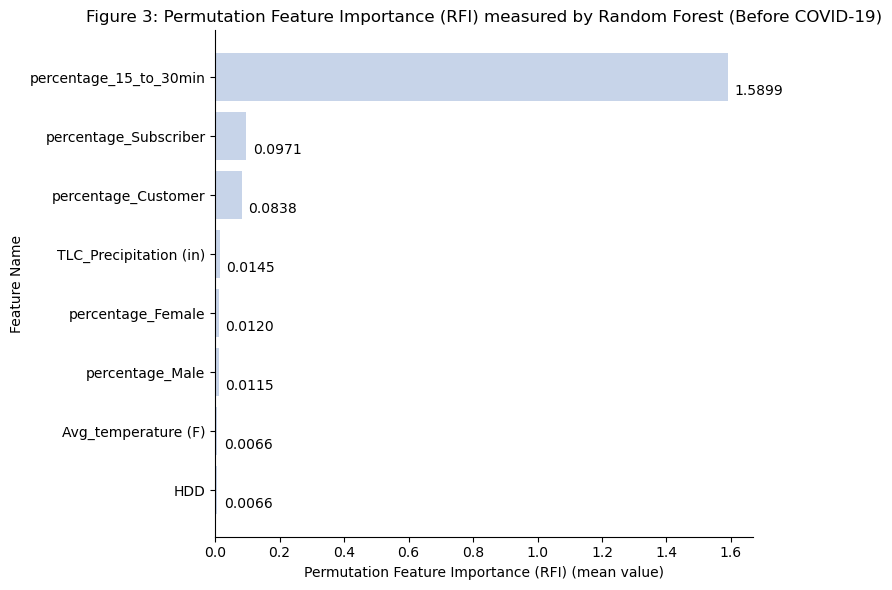

In [664]:
# plot the rank
importance_B_sorted = importance_B.sort_values(by='Absolute Importance(B)', ascending=True)

# change the colour, the positive value is blue, 
# and the negative value is red
importance_B_sorted['Color'] = np.where(importance_B_sorted['Importance(B)'] >= 0,'#C7D4E9','#F4C7C9')

fig, ax = plt.subplots(figsize=(8, 6))
bars = ax.barh(importance_B_sorted['Feature'], 
               importance_B_sorted['Importance(B)'], 
               color=importance_B_sorted['Color'])
# title
ax.set_title("Figure 3: Permutation Feature Importance (RFI) measured by Random Forest (Before COVID-19)")
# increase the name of features
for bar in bars.patches:
    ax.text(bar.get_width() + 0.02, bar.get_y() + 0.1, '{:.4f}'.format(bar.get_width()), fontsize=10)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_xlabel('Permutation Feature Importance (RFI) (mean value)')
ax.set_ylabel('Feature Name')

fig.tight_layout()
plt.show()

In [665]:
# After
After_importance = permutation_importance(RFA_final, test_x_A, test_y_A, 
                                           n_repeats=30, random_state=randomState_dt)
# Extract the importance results of features ( Mean, std and abs)
Result_A = After_importance.importances_mean
std_A = After_importance.importances_std
abs_Result_A = abs(Result_A)
# Extract the name of feature
feature_names = test_x_A.columns
# Create the dataframe
importance_A = pd.DataFrame({'Feature': feature_names, 
                             'Importance(A)': Result_A,
                             'Absolute Importance(A)': abs_Result_A,
                             'Std Deviation (A)': std_A})
# Sort by absolute importance from high to low
importance_A = importance_A.sort_values(by='Absolute Importance(A)', 
                                        ascending=False)
# extract the rank
importance_A['Rank(A)'] = importance_A['Absolute Importance(A)'].rank(ascending=False)
# Convert ranking number to integer type
importance_A['Rank(A)'] = importance_A['Rank(A)'].astype(int)
print("Table 9: The Relative Importance Ranking of Features after COVID-19")
# print the results
importance_A

Table 9: The Relative Importance Ranking of Features after COVID-19


,Feature,Importance(A),Absolute Importance(A),Std Deviation (A),Rank(A)
4,percentage_Male,0.335736,0.335736,0.083639,1
3,percentage_Female,0.236749,0.236749,0.060935,2
6,HDD,0.130355,0.130355,0.050669,3
0,percentage_15_to_30min,0.086665,0.086665,0.023387,4
1,percentage_above30min,0.070321,0.070321,0.019331,5
5,Avg_temperature (F),0.041662,0.041662,0.012281,6
7,CDD,0.029587,0.029587,0.011729,7
2,percentage_Customer,0.016893,0.016893,0.006625,8


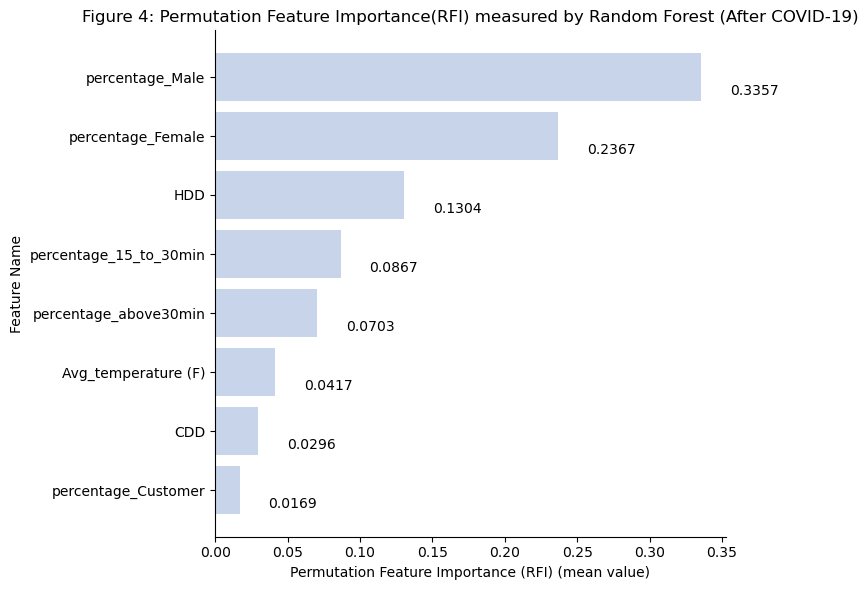

In [666]:
# plot the rank
importance_A_sorted = importance_A.sort_values(by='Absolute Importance(A)', ascending=True)

# change the colour, the positive value is blue, 
# and the negative value is red
importance_A_sorted['Color'] = np.where(importance_A_sorted['Importance(A)'] >= 0,'#C7D4E9','#F4C7C9')
fig, ax = plt.subplots(figsize=(8, 6))
bars = ax.barh(importance_A_sorted['Feature'], 
               importance_A_sorted['Importance(A)'], 
               color=importance_A_sorted['Color'])
# title
ax.set_title("Figure 4: Permutation Feature Importance(RFI) measured by Random Forest (After COVID-19)")
# increase the name of features
for bar in bars.patches:
    ax.text(bar.get_width() + 0.02, bar.get_y() + 0.1, '{:.4f}'.format(bar.get_width()), fontsize=10)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_xlabel('Permutation Feature Importance (RFI) (mean value)')
ax.set_ylabel('Feature Name')
fig.tight_layout()
plt.show()

## 6. RESULTS & DISCUSSION

### 6.1 The Performance Comparison of RF and XGBoost

Both RF and XGBoost models are trained, and Table 10 summarises the hyperparameter settings derived from the training sets. Table 6 displays the performance indicators of two models across the two periods, revealing higher R² values and lower RMSE values in the training sets compared to the testing sets for both models. This observation reflects a probability of overfitting. However, compared to XGBoost, RF reports more stable results since it has minor differences between training and testing sets. 

By assessing the testing sets, the main advantages of RF are stability and generalisation, particularly evident in the variance in the two periods (Table 7). Conversely, XGBoost exhibits a major strength in relatively lower bias. Considering the research direction of comparing prediction performance pre- and post-COVID-19, RF is chosen to assess feature importance, as it possesses the advantages of stability and generalisation.

Table 10: The hyperparameter Settings of each Model

|Target variable |Model|Data Size (Training/Testing) |Parameter Setting|
|:---|:---|:---|:---|
|Daily BSS Trip(Before)| Random Forest|132/45 |'max_depth': 10,'min_samples_split': 2|
||XGBoost||'max_depth': 20, 'n_estimators': 50. The other parameters in XGBoost are the default options.|
|Daily BSS Trip(After)|Random Forest |143/48|'max_depth': 20, 'min_samples_split': 4|
||XGBoost||'max_depth': 20, 'n_estimators': 50. The other parameters in XGBoost are the default options.|

Note:[1] 'max_depth' refers to the maximal depth (or height) of a tree.  
[2] 'min_samples_split' refers to the minimum number of samples to split a node.  
[3] 'n_estimators' refers to the number of trees in the ensemble. 

### 6.2 The Relative Importance of Features

Figures 3 and 4 reveal changes in feature importance between before and after COVID-19, indicating the influences of COVID-19 on travel choices and patterns.

The results from both periods demonstrate a positive correlation between some weather features and BSS demand. However, the post-COVID-19 changes are mainly reflected in HDD (3rd) and CDD (7th), which indicates that the increase in BSS demand is primarily related to cooler weather and the impact of hot weather is relatively small. This is consistent with the finding of Kim (2018), which suggests that temperature is positively correlated with BSS demand, but when the temperature reaches a certain threshold, its impact on demand begins to diminish.

Regarding travel patterns, the percentage of 15 to 30 minutes is the most significant feature before COVID-19, far outweighing other features. However, after COVID-19, its ranking has declined, with the percentage of above 30 minutes following closely behind. This further confirms the gradual shift in travel patterns due to COVID-19, with users showing a preference to choose BSS for longer distances.

Gender percentages are crucial in predicting BSS demand after COVID-19. Although the relative importance ranking of females percentage has increased after COVID-19, it is lower than that of males percentage, contrasting with the findings of Uddin, Hwang, and Hasnine (2023) during COVID-19. The subscriber percentage is considered unimportant for predicting BSS demand after COVID-19, and the relative importance of customer percentage has decreased. This may be due to the impacts of COVID-19 on travel choices and the policies encouraging travel shifts to use BSS, demonstrating an increase in the customer percentage.


## 7. CONCLUSION

In conclusion, the research examined the feature differences for predicting BSS demand before and after COVID-19 by comparing the performance of ML methods. The results indicated that the two periods show distinct differences in relative feature importance, possibly due to changes in travel choices and travel patterns caused by COVID-19. Thus, BSS operators should consider these features to meet the new needs further. However, the research has some limitations. Some results differ from previous studies. For instance, TLC is positively related to BSS demand. This could be attributed to variances in the time range of data. This research measures the daily trip, however, Ashqar, Elhenawy and Rakha (2019) highlighted that measuring in hours may provide more accurate results, which deserves further exploration in future studies. Additionally, this study optimises the model using RFE, and further exploration of methods to enhance ML performance is essential.


## REFERENCE

Ashqar, H. I., Elhenawy, M. and Rakha, H. A. (2019). ‘Modeling bike counts in a bike-sharing system considering the effect of weather conditions’. Case Studies on Transport Policy, 7 (2), pp. 261–268. doi: 10.1016/j.cstp.2019.02.011.
<br>
<br>
Ashraf, M. T., Hossen, M. A., Dey, K., El-Dabaja, S., Aljeri, M. and Naik, B. (2021). ‘Impacts of Bike Sharing Program on Subway Ridership in New York City’. Transportation Research Record: Journal of the Transportation Research Board, 2675 (9), pp. 924–934. doi: 10.1177/03611981211004980.
<br>
<br>
Bachand-Marleau, J., Lee, B. H. Y. and El-Geneidy, A. M. (2012). ‘Better Understanding of Factors Influencing Likelihood of Using Shared Bicycle Systems and Frequency of Use’. Transportation Research Record: Journal of the Transportation Research Board, 2314 (1), pp. 66–71. doi: 10.3141/2314-09.
<br>
<br>
Blazanin, G., Mondal, A., Asmussen, K. E. and Bhat, C. R. (2022). ‘E-scooter sharing and bikesharing systems: An individual-level analysis of factors affecting first-use and use frequency’. Transportation Research Part C: Emerging Technologies, 135, p. 103515. doi: 10.1016/j.trc.2021.103515.
<br>
<br>
Chibwe, J., Heydari, S., Faghih Imani, A. and Scurtu, A. (2021). ‘An exploratory analysis of the trend in the demand for the London bike-sharing system: From London Olympics to Covid-19 pandemic’. Sustainable Cities and Society, 69, p. 102871. doi: 10.1016/j.scs.2021.102871.
<br>
<br>
Corcoran, J., Li, T., Rohde, D., Charles-Edwards, E. and Mateo-Babiano, D. (2014). ‘Spatio-temporal patterns of a Public Bicycle Sharing Program: the effect of weather and calendar events’. Journal of Transport Geography, 41, pp. 292–305. doi: 10.1016/j.jtrangeo.2014.09.003.
<br>
<br>
El-Assi, W., Salah Mahmoud, M. and Nurul Habib, K. (2017). ‘Effects of built environment and weather on bike sharing demand: a station level analysis of commercial bike sharing in Toronto’. Transportation, 44 (3), pp. 589–613. doi: 10.1007/s11116-015-9669-z.
<br>
<br>
Engbers, L. H. and Hendriksen, I. J. (2010). ‘Characteristics of a population of commuter cyclists in the Netherlands: perceived barriers and facilitators in the personal, social and physical environment’. International Journal of Behavioral Nutrition and Physical Activity, 7 (1), p. 89. doi: 10.1186/1479-5868-7-89.
<br>
<br>
Feng, Y. and Wang, S. (2017). ‘A forecast for bicycle rental demand based on random forests and multiple linear regression’. in 2017 IEEE/ACIS 16th International Conference on Computer and Information Science (ICIS). 2017 IEEE/ACIS 16th International Conference on Computer and Information Science (ICIS), Wuhan, China: IEEE, pp. 101–105. doi: 10.1109/ICIS.2017.7959977.
<br>
<br>
Goh, H., Choi, G. and Song, Y. (2023). ‘How the COVID-19 pandemic changed travel behaviour? A case study on public bikes in Seoul’. Research in Transportation Economics, 101, p. 101339. doi: 10.1016/j.retrec.2023.101339.
<br>
<br>
Gregorutti, B., Michel, B. and Saint-Pierre, P. (2017). ‘Correlation and variable importance in random forests’. Statistics and Computing, 27 (3), pp. 659–678. doi: 10.1007/s11222-016-9646-1.
<br>
<br>
Hu, Y., Sun, Z., Li, W. and Pei, L. (2022). ‘Forecasting public bicycle rental demand using an optimized eXtreme Gradient Boosting model’. Journal of Intelligent & Fuzzy Systems, 42 (3), pp. 1783–1801. doi: 10.3233/JIFS-211202.
<br>
‘<br>
Jia, J., Liu, C., Wang, X., Zhang, H. and Xiao, Y. (2023). ‘Understanding bike-sharing mobility patterns in response to the COVID-19 pandemic’. Cities, 142, p. 104554. doi: 10.1016/j.cities.2023.104554.
<br>
<br>
Kim, K. (2018). ‘Investigation on the effects of weather and calendar events on bike-sharing according to the trip patterns of bike rentals of stations’. Journal of Transport Geography, 66, pp. 309–320. doi: 10.1016/j.jtrangeo.2018.01.001.
<br>
<br>
Kim, M. and Cho, G.-H. (2022). ‘Examining the causal relationship between bike-share and public transit in response to the COVID-19 pandemic’. Cities, 131, p. 104024. doi: 10.1016/j.cities.2022.104024.
<br>
<br>
Lainjo, Bongs. (2022). Application of Machine Learning in Predicting the Number of Bike Share Riders. InternationalJournal Business, Management, and Economics, 3(4).  339-370.  DOI: https://doi.org/10.47747/ijbme.v3i4.865.
<br>
<br>
Li, A. and Axhausen, K. W. (2019). ‘Comparison of short-term traffic demand prediction methods for transport services’. [object Object], p. 16 p. doi: 10.3929/ETHZ-B-000356143.
<br>
<br>
Li, H., Zhang, Y., Zhu, M. and Ren, G. (2021). ‘Impacts of COVID-19 on the usage of public bicycle share in London’. Transportation Research Part A: Policy and Practice, 150, pp. 140–155. doi: 10.1016/j.tra.2021.06.010.
<br>
<br>
Lyft (2021) *December 2021 Monthly Report*. Available at: https://mot-marketing-whitelabel-prod.s3.amazonaws.com/nyc/December-2021-Citi-Bike-Monthly-Report.pdf (Accessed: 7 April 2024).
<br>
<br>
Lyft (2020) *December 2019 Monthly Report*. Available at: https://d21xlh2maitm24.cloudfront.net/nyc/December-2019-Citi-Bike-Monthly-Report.pdf?mtime=20200218125724 (Accessed: 7 April 2024).
<br>
<br>
Ma, X., Zhang, X., Li, X., Wang, X. and Zhao, X. (2019). ‘Impacts of free-floating bikesharing system on public transit ridership’. Transportation Research Part D: Transport and Environment, 76, pp. 100–110. doi: 10.1016/j.trd.2019.09.014.
<br>’
<br>
National Centers for Environmental Information (NCEI) (2024) *Local Climatological Data Station Details:NY CITY CENTRAL PARK, NY US*.Available at: https://www.ncdc.noaa.gov/cdo-web/datasets/LCD/stations/WBAN:94728/detail  (Accessed: 7 April 2024).
<br>	
<br>			
National Centers for Environmental Information (NCEI) (2024) *NWS New York Significant Weather Events Archive*.Available at: https://www.weather.gov/okx/stormevents (Accessed: 7 April 2024).
<br>
<br>
Padmanabhan, V., Penmetsa, P., Li, X., Dhondia, F., Dhondia, S. and Parrish, A. (2021). ‘COVID-19 effects on shared-biking in New York, Boston, and Chicago’. Transportation Research Interdisciplinary Perspectives, 9, p. 100282. doi: 10.1016/j.trip.2020.100282.
<br>
<br>
Reilly, K. H., Wang, S. M. and Crossa, A. (2022). ‘Gender disparities in New York City bike share usage’. International Journal of Sustainable Transportation, 16 (3), pp. 237–245. doi: 10.1080/15568318.2020.1861393.
<br>
<br>
Teixeira, J. F., Silva, C. and Moura E Sá, F. (2021). ‘The motivations for using bike sharing during the COVID-19 pandemic: Insights from Lisbon’. Transportation Research Part F: Traffic Psychology and Behaviour, 82, pp. 378–399. doi: 10.1016/j.trf.2021.09.016.
<br>
<br>
Uddin, M., Hwang, H.-L. and Hasnine, M. S. (2023). ‘An interpretable machine learning framework to understand bikeshare demand before and during the COVID-19 pandemic in New York City’. Transportation Planning and Technology, 46 (4), pp. 482–498. doi: 10.1080/03081060.2023.2201280.
<br>
<br>
Wang, H. and Noland, R. B. (2021). ‘Bikeshare and subway ridership changes during the COVID-19 pandemic in New York City’. Transport Policy, 106, pp. 262–270. doi: 10.1016/j.tranpol.2021.04.004.
<br>
<br>
Scikit-learn (no date_a)*Recursive Feature Elimination (RFE)*. Available at: https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html (Accessed: 20 April 2024).
<br>
<br>
Scikit-learn (no date_b)*Permutation Importance vs Random Forest Feature Importance (MDI)*. Available at: https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance.html#sphx-glr-auto-examples-inspection-plot-permutation-importance-py (Accessed: 18 April 2024).
<br>
<br>
